## Regressão Logística com o R

Olá! 

Para começarmos a regressão logística, precisaremos destas seguintes bibliotecas no R. Caso não tenha alguma delas, poderá inserir o código `install.packages("packagename")`. 

In [5]:
#install.packages("caret")

library(titanic) 
library(aod)
library(ggplot2)
library(dummies)
library(caret)
library(ROCR)

In [6]:
data("titanic_train")
data("titanic_test")


In [8]:
## Setting Survived column for test data to NA
titanic_test$Survived <- NA

## Combining Training and Testing dataset
complete_data <- rbind(titanic_train, titanic_test)

## Check data structure
str(complete_data)


## Let's check for any missing values in the data
colSums(is.na(complete_data))
## PassengerId    Survived      Pclass        Name         Sex         Age 
##           0         418           0           0           0         263 
##       SibSp       Parch      Ticket        Fare       Cabin    Embarked 
##           0           0           0           1           0           0

## Checking for empty values
colSums(complete_data=='')
## PassengerId    Survived      Pclass        Name         Sex         Age 
##           0          NA           0           0           0          NA 
##       SibSp       Parch      Ticket        Fare       Cabin    Embarked 
##           0           0           0          NA        1014           2

## Check number of uniques values for each of the column to find out columns which we can convert to factors
sapply(complete_data, function(x) length(unique(x)))
## PassengerId    Survived      Pclass        Name         Sex         Age 
##        1309           3           3        1307           2          99 
##       SibSp       Parch      Ticket        Fare       Cabin    Embarked 
##           7           8         929         282         187           4

## Missing values imputation
complete_data$Embarked[complete_data$Embarked==""] <- "S"
complete_data$Age[is.na(complete_data$Age)] <- median(complete_data$Age,na.rm=T)

## Removing Cabin as it has very high missing values, passengerId, Ticket and Name are not required
library(dplyr)
titanic_data <- complete_data %>% select(-c(Cabin, PassengerId, Ticket, Name))

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

PassengerId    Survived      Pclass        Name         Sex         Age 
          0          NA           0           0           0          NA 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0          NA        1014           2

PassengerId    Survived      Pclass        Name         Sex         Age 
       1309           3           3        1307           2          99 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           8         929         282         187           4

In [9]:
## Converting "Survived","Pclass","Sex","Embarked" to factors
for (i in c("Survived","Pclass","Sex","Embarked")){
  titanic_data[,i]=as.factor(titanic_data[,i])
}

## Create dummy variables for categorical variables
library(dummies)
titanic_data <- dummy.data.frame(titanic_data, names=c("Pclass","Sex","Embarked"), sep="_")


In [10]:
## Splitting training and test data
train <- titanic_data[1:667,]
test <- titanic_data[668:889,]


In [11]:
## Model Creation
model <- glm(Survived ~.,family=binomial(link='logit'),data=train) 
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3804  -0.6562  -0.4300   0.6392   2.3950  

Coefficients: (3 not defined because of singularities)
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.373105   0.319779  -4.294 1.76e-05 ***
Pclass_1     2.175104   0.359365   6.053 1.42e-09 ***
Pclass_2     1.302268   0.271680   4.793 1.64e-06 ***
Pclass_3           NA         NA      NA       NA    
Sex_female   2.677814   0.226863  11.804  < 2e-16 ***
Sex_male           NA         NA      NA       NA    
Age         -0.031671   0.008945  -3.540 0.000399 ***
SibSp       -0.248975   0.123365  -2.018 0.043570 *  
Parch       -0.091603   0.141950  -0.645 0.518718    
Fare        -0.001397   0.003179  -0.440 0.660254    
Embarked_C   0.431447   0.271693   1.588 0.112288    
Embarked_Q   0.533193   0.369337   1.444 0.148837    
Embarked_S         NA         NA      N

In [12]:
## Using anova() to analyze the table of devaiance
anova(model, test="Chisq")


,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,666,891.9935,NA
Pclass_1,1,39.60284205,665,852.3907,3.112300e-10
Pclass_2,1,26.48541414,664,825.9053,2.655355e-07
Pclass_3,0,0.00000000,664,825.9053,NA
Sex_female,1,197.97805764,663,627.9272,5.768673e-45
Sex_male,0,0.00000000,663,627.9272,NA
Age,1,8.98569376,662,618.9415,2.721015e-03
SibSp,1,8.11372509,661,610.8278,4.393136e-03
Parch,1,0.99761304,660,609.8302,3.178888e-01
Fare,1,0.04360609,659,609.7866,8.345882e-01


In [13]:
## Predicting Test Data
result <- predict(model,newdata=test,type='response')
result <- ifelse(result > 0.5,1,0)

## Confusion matrix and statistics
library(caret)
confusionMatrix(data=result, reference=test$Survived)
## Confusion Matrix and Statistics
## 
##           Reference
## Prediction   0   1
##          0 128  25
##          1  13  56
##                                           
##                Accuracy : 0.8288          
##                  95% CI : (0.7727, 0.8759)
##     No Information Rate : 0.6351          
##     P-Value [Acc > NIR] : 1.817e-10       
##                                           
##                   Kappa : 0.6187          
##  Mcnemar's Test P-Value : 0.07435         
##                                           
##             Sensitivity : 0.9078          
##             Specificity : 0.6914          
##          Pos Pred Value : 0.8366          
##          Neg Pred Value : 0.8116          
##              Prevalence : 0.6351          
##          Detection Rate : 0.5766          
##    Detection Prevalence : 0.6892          
##       Balanced Accuracy : 0.7996          
##                                           
##        'Positive' Class : 0               
## 

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

ERROR: Error in requireNamespaceQuietStop("e1071"): package e1071 is required


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

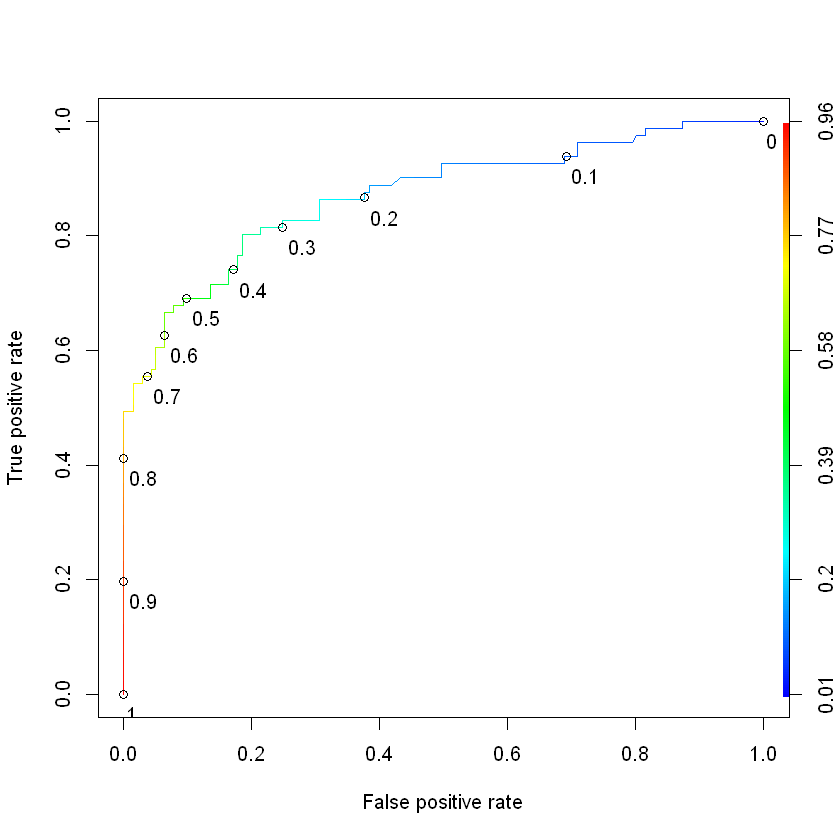

In [14]:
## ROC Curve and calculating the area under the curve(AUC)
library(ROCR)
predictions <- predict(model, newdata=test, type="response")
ROCRpred <- prediction(predictions, test$Survived)
ROCRperf <- performance(ROCRpred, measure = "tpr", x.measure = "fpr")

plot(ROCRperf, colorize = TRUE, text.adj = c(-0.2,1.7), print.cutoffs.at = seq(0,1,0.1))

In [16]:
auc <- performance(ROCRpred, measure = "auc")
auc <- auc@y.values[[1]]
auc


[1] 0.8714211

#para 
- pedro
- pablo